In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Quantum measurements: 
# Single-qubit operators

<a id="Introduction"></a>
## Introduction

In this notebook, we will learn the theory behind the computation of expectation values of single-qubit operators, and how to calculate them in Qiskit. This notebook does not use advanced functionalities but relies on manual circuit construction to transparently explain the theory step by step.

In [2]:
import numpy as np

from qiskit_aer.primitives import Sampler
from qiskit import QuantumCircuit

from qiskit.quantum_info.operators import SparsePauliOp, Operator
from qiskit.quantum_info.states import Statevector

For more information on `quantum_info` package: https://qiskit.org/documentation/apidoc/quantum_info.html

## A. A diagonal operator
<a id="diag_op"></a>

### Define the operator 
Let's use a single-qubit case, and begin with a simple diagonal operator: $O = Z$.

In [3]:
op = SparsePauliOp('Z')
print(type(op))
print(op.to_matrix())

<class 'qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp'>
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


### Define the wavefunction ####
Let's parametrize the wavefunction as: $ | \psi \rangle = cos(\theta/2)~ | 0 \rangle + sin(\theta/2) e^{i\theta} ~| 1 \rangle $.

This is achieved by using an $R_y(\theta)$ gate:

$R_y(\theta)$ = $exp(-i \frac{\theta}{2}Y) = 
\begin{pmatrix}
cos\frac{\theta}{2} & -sin\frac{\theta}{2} \\
sin\frac{\theta}{2} & cos\frac{\theta}{2} 
\end{pmatrix} $

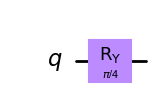

In [4]:
circuit = QuantumCircuit(1)
theta = np.pi/4 #just a arbitrary value
circuit.ry(theta,0)
circuit.draw(output='mpl')

In Qiskit, quantum states are represented by concrete subclasses of the abstract class `QuantumState`. There are three representations of quantum states: 

- `Statevector`
- `DensityMatrix`
- `StabilizerState`

In the following we will use the `Statevector` to represent a state. A `Statevector` can be built from a quantum circuit.

In [5]:
psi = Statevector(circuit)
psi.draw('text')


[0.92387953+0.j,0.38268343+0.j]

### Evaluate the expectation value the exact way ####
Formally, $\hat{O} = \langle \psi | O | \psi \rangle$

where we use the usual bra-ket notation, in which the bra is the conjugate of the ket. 

In [6]:
exact_expectation = psi.expectation_value(op).real
print('Exact expectation value:', exact_expectation)

Exact expectation value: 0.7071067811865475


### Evaluate the expectation value as the quantum computer does ####
Recall that we cannot access the full state vector $| \psi \rangle$ directly, so we cannot do the scalar product directly.

It follows from definition, however, that if $O$ has a set of eigenfunctions $\phi_j$ with eigenvalues $c_j$, then

$ \hat{O} = \sum_j c_j | \langle\phi_j| \psi \rangle |^2$.

For $O = Z$, the eigenfunctions are the basis states already (Z is diagonal), so $|0\rangle$ with eigenvalue $+1$, and $|1\rangle$ with eigenvalue $-1$. This follows from the definition of $Z$ (see matrix form above).

Therefore, $| \langle \phi_j| \psi \rangle |^2  = ~|\langle0| \psi \rangle |^2 $ or $| \langle1| \psi \rangle |^2$ is the probability of measuring the strings '0' and '1'.

Then, 
$ \hat{O} = +1 \times prob(0) ~ - 1 \times prob(1) $.


Equivalently, if we write $| \psi \rangle = \begin{pmatrix}
a \\
  b
\end{pmatrix}$,

$ \hat{Z}  = \langle \psi | Z | \psi \rangle =  ( a ~ b ) ~\begin{pmatrix}
1 & 0\\
  0 & -1 
\end{pmatrix} \begin{pmatrix}
a \\
  b
\end{pmatrix} = |a|^2 - |b|^2 = prob(0) -  prob(1) $.

Let's simulate running this circuit with $n$ shots, adding the measurements stage and classical register.

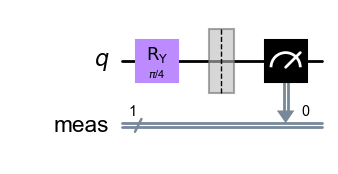

In [7]:
circuit.measure_all()
circuit.draw(output='mpl')

We are using the `Sampler` primitive from `qiskit_aer` to compute the quantum circuit. The `Sampler` uses the `Aer` qiskit simulator.

In [8]:
nshots = 40024
sampler = Sampler()
result = sampler.run(circuit, shots=nshots).result()
print(result)
# the useful data is in the quasi_dist list; each element from the list
# corresponds to a circuit, therefore we take the first element from this list
quasi_dist = result.quasi_dists[0]


SamplerResult(quasi_dists=[{1: 0.14741155306815912, 0: 0.8525884469318409}], metadata=[{'shots': 40024, 'simulator_metadata': {'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.003957959, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'device': 'CPU', 'active_input_qubits': [0], 'measure_sampling': True, 'num_clbits': 1, 'input_qubit_map': [[0, 0]], 'num_qubits': 1, 'method': 'statevector', 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enabled': True}}}])


In [9]:
prob_0 = quasi_dist[0]
prob_1 = quasi_dist[1]

print(prob_0, prob_1)

0.8525884469318409 0.14741155306815912


In [10]:
expectation_from_counts = +1 * prob_0 -1 * prob_1
print('Expectation from counts (manual way):', expectation_from_counts)
print('Exact expectation (scalar product):', exact_expectation)

Expectation from counts (manual way): 0.7051768938636818
Exact expectation (scalar product): 0.7071067811865475


## B. A non-diagonal operator
<a id="nondiag_op"></a>

In [11]:
op = SparsePauliOp('X')
print(type(op))
print (op.to_matrix())

<class 'qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp'>
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]


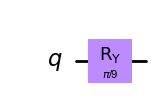

In [12]:
circuit = QuantumCircuit(1)
theta = np.pi/9 #just an arbitrary value
circuit.ry(theta,0)
circuit.draw(output='mpl')

In [13]:
psi = Statevector(circuit)
psi.draw('text')

[0.98480775+0.j,0.17364818+0.j]

### Evaluate the expectation value the exact way 
Formally, $ \hat{O} = \langle \psi | O | \psi \rangle$

In this case, nothing changes:

In [14]:
exact_expectation = psi.expectation_value(op).real
print('Exact expectation value:', exact_expectation)

Exact expectation value: 0.34202014332566866


### Evaluate the expectation value as the quantum computer does

This time the eigenfunctions of $O$ are not the computational basis states $|0\rangle $ or $ |1\rangle$!

Since we can measure the qubits only in the computational basis, we have to rotate the qubit accordingly using an unitary operator (rotation) $R$, such that the eigenfunctions of $O$ are aligned to the ones of $Z$.

Formally,

$\hat{O} = \langle \psi | O | \psi \rangle = \langle \psi | R^{-1} R O R^{-1} R | \psi \rangle = \langle \psi' |  R O R^{-1}  | \psi' \rangle$, and $| \psi' \rangle = R | \psi \rangle$.

The eigenfunctions of $X$ are ${1 \over \sqrt{2}} \big(|0 \rangle \pm |1\rangle \big) $, and the rotation operator is exactly the Hadamard operator (gate).

In [15]:
# R^-1 O R
op_circuit = QuantumCircuit(1)
op_circuit.h(0)
op_circuit.x(0)
op_circuit.h(0)
op_diagonalized = Operator(op_circuit)
print(op_circuit)
print(op_diagonalized.to_matrix())

   ┌───┐┌───┐┌───┐
q: ┤ H ├┤ X ├┤ H ├
   └───┘└───┘└───┘
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


Now we measure $Z$ again, but we have to perform a single-qubit rotation before the measurement.

Let's simulate running this circuit with $n$ shots, adding the measurements stage and classical register.

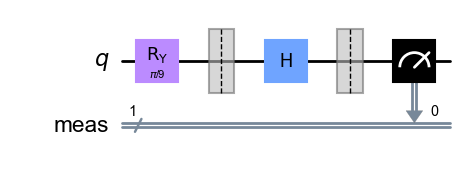

In [16]:
circuit = QuantumCircuit(1) #re-initialize it for re-running convenience
circuit.ry(theta,0)

circuit.barrier()
circuit.h(0) #notice the rotation here

circuit.measure_all()
circuit.draw(output='mpl')

In [17]:
nshots = 60024
sampler = Sampler()
result = sampler.run(circuit, shots=nshots).result()
quasi_dist = result.quasi_dists[0]
prob_0 = quasi_dist[0]
prob_1 = quasi_dist[1]

print(prob_0, prob_1)
expectation_from_counts = +1*prob_0 -1*prob_1
print('Expectation from counts (manual way):', expectation_from_counts)
print('Exact expectation (scalar product):', exact_expectation)

0.671864587498334 0.328135412501666
Expectation from counts (manual way): 0.343729174996668
Exact expectation (scalar product): 0.34202014332566866


### Generalization to sum of operators ###
The one-qubit case is peculiar, because even if $O = \lambda_0 Z + \lambda_1 X + \lambda_2 Y$, it is always possible to figure out a rotation $R$ such that we are aligned with the eigenfunctions of $O$.

---
*IBM - existing work*

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>